In [49]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from time import perf_counter
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Loading Datasets Path

In [50]:
# Loading ALL images, really all
dir_path = "../../data/CUSTOM"
paths = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]

In [51]:
test_image_path = '../../data/other/lenna.png'
original_gray_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

In [52]:
factors_to_show = [4, 64, 256]

# Metrics for Comparison

In [53]:
def average_time(method, *args, iters_number=10):
    times = []
    for i in range(iters_number):
        time_start = perf_counter()
        method(*args)
        time_stop = perf_counter()
        times.append(time_stop - time_start)
    return np.mean(times)

In [54]:
def compression_factor(size_original, size_compressed):
    return size_original / size_compressed

In [55]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Discrete Cosine Transform

In [56]:
def dct_compress_image_with_thresh(original_image, keep):
    coeffs = sp.fftpack.dctn(original_image, norm='ortho')
    Csort = np.sort(np.abs(coeffs.reshape(-1)))

    thresh = Csort[int(np.floor((1 - keep) * len(Csort)))]
    ind = np.abs(coeffs) > thresh
    Cfiltered = coeffs * ind

    return Cfiltered

def dct_reconstruct_image(coeffs):
    return sp.fftpack.idctn(coeffs, norm='ortho')

def dct_statistics(original_image, keep):
    Cfiltered = dct_compress_image_with_thresh(original_image, keep)

    compr_time = average_time(dct_compress_image_with_thresh, original_image, keep)
    compr_factor = compression_factor(Cfiltered.size, np.sum(np.abs(Cfiltered) > 0))

    reconstructed_image = dct_reconstruct_image(Cfiltered)

    psnr_ = psnr(original_image, reconstructed_image, data_range=original_image.max() - reconstructed_image.min())
    ssim_ = ssim(original_image, reconstructed_image, data_range=original_image.max() - reconstructed_image.min())

    return reconstructed_image, compr_time, compr_factor, psnr_, ssim_

## Testing on Lenna Image

In [57]:
dct_compressed_images = list()

for factor in factors_to_show:
    keep = 1. / factor
    
    dct_compr_image, _, _, _, _ = dct_statistics(original_gray_image, keep)
    dct_compressed_images.append(dct_compr_image)

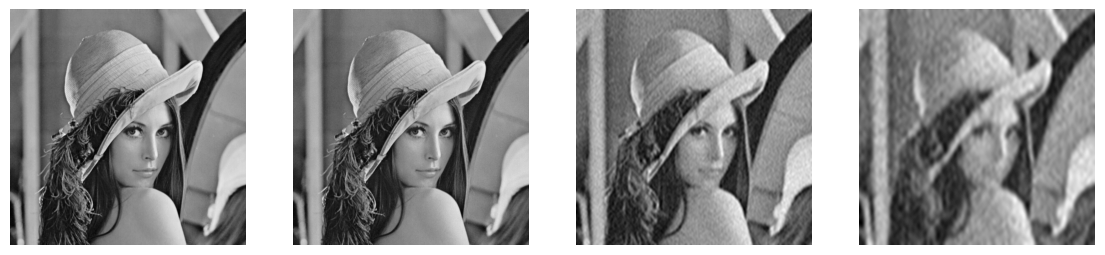

In [58]:
plt.figure(figsize=(14, 8))

plt.subplot(1, len(factors_to_show) + 1, 1)
plt.imshow(original_gray_image, cmap='gray')
plt.axis('off')

for j, factor in enumerate(factors_to_show, start=1):
    plt.subplot(1, len(factors_to_show) + 1, j + 1)
    plt.imshow(dct_compressed_images[j - 1], cmap='gray')
    plt.axis('off')

## Testing on Datasets

In [61]:
factors_to_show = [4, 16, 64, 256, 1024]
keeps = np.concatenate([np.linspace(0.0009, 0.9999, 50), 1. / np.array(factors_to_show)])
keeps.sort()

dct_compression_times = list()
dct_compression_factors = list()
dct_psnrs = list()
dct_ssims = list()

for keep in tqdm(keeps):
    compression_times_per_keep = list()
    compression_factors_per_keep = list()
    psnrs_per_keep = list()
    ssims_per_keep = list()
    
    for image in paths:
        original_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        
        dct_compr_image, dct_compr_time, dct_compr_factor, dct_psnr, dct_ssim = dct_statistics(original_image, keep)
        
        compression_times_per_keep.append(dct_compr_time)
        compression_factors_per_keep.append(dct_compr_factor)
        psnrs_per_keep.append(dct_psnr)
        ssims_per_keep.append(dct_ssim)
    
    dct_compression_times.append(np.mean(compression_times_per_keep))
    dct_compression_factors.append(np.mean(compression_factors_per_keep))
    dct_psnrs.append(np.mean(psnrs_per_keep))
    dct_ssims.append(np.mean(ssims_per_keep))        

100%|██████████| 55/55 [12:04<00:00, 13.18s/it]


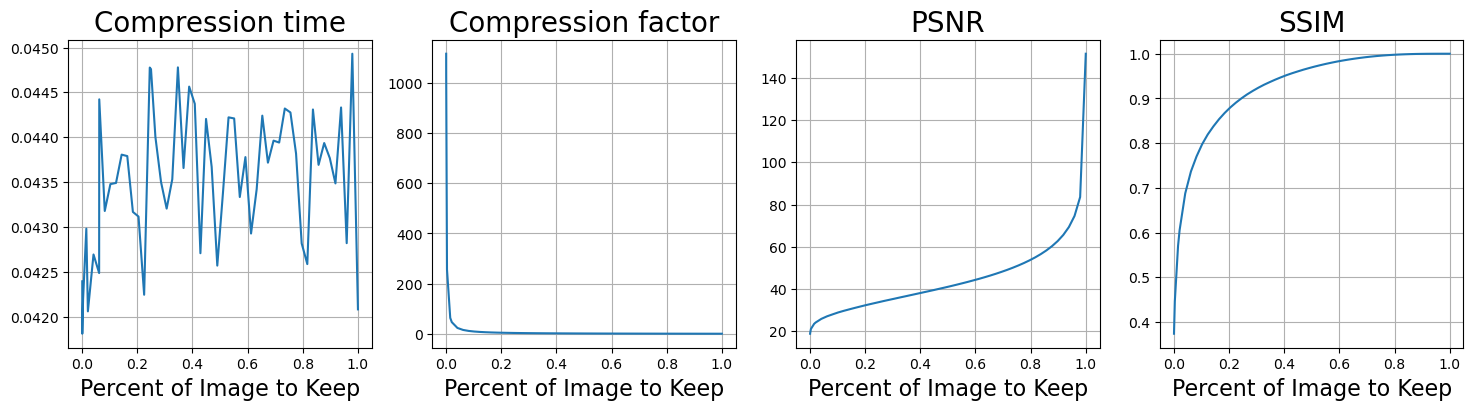

In [62]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 4, 1)
plt.plot(keeps, dct_compression_times)
plt.title('Compression time', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.grid(True)

plt.subplot(1, 4, 2)
plt.plot(keeps, dct_compression_factors)
plt.title('Compression factor', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.grid(True)

plt.subplot(1, 4, 3)
plt.plot(keeps, dct_psnrs)
plt.title('PSNR', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.grid(True)

plt.subplot(1, 4, 4)
plt.plot(keeps, dct_ssims)
plt.title('SSIM', fontsize = 20)
plt.xlabel('Percent of Image to Keep', fontsize = 16)
plt.grid(True)